In [1]:
import torch
import pytorch_lightning as pl

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

from hydra.experimental import initialize, compose

from bliss import sleep
from bliss.datasets import simulated, sdss

import numpy as np
import time 

torch.manual_seed(184)
np.random.seed(143)

1.7.1
cuda:0


In [2]:
%matplotlib inline

# Load configs and model

In [3]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [4]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [5]:
model_filename = './fits/starnet'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [6]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

# Load m2 data

In [7]:
import sys
sys.path.append('./m2_utils/')
import m2_data
import plotting

In [8]:
run = 2583
camcol = 2
field = 136

sdss_frame, hubble_catalog, sdss_background = \
    m2_data.load_m2_data()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ./hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [9]:
# filter by bright stars 
fmin = 1000.
hubble_catalog = plotting.filter_catalog(hubble_catalog,
                                         hubble_catalog['fluxes'][:, 0] > fmin)

### We focus on this chunk

In [10]:
x0 = 630
x1 = 310
chunk_slen = 100

In [11]:
border_padding = sleep_net.image_encoder.border_padding

In [12]:
sdss_test_image = plotting.crop_image(sdss_frame, 
                                 x0 - border_padding, 
                                 x1 - border_padding,
                                 chunk_slen + 2 * border_padding,
                                 chunk_slen + 2 * border_padding)

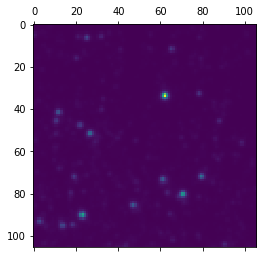

In [13]:
plt.matshow(sdss_test_image[0])

### get map estimates

In [14]:
map_estimate = sleep_net.image_encoder.map_estimate(sdss_test_image.unsqueeze(0).to(device), 
                                                    sleep_net.image_decoder.slen)

# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * sleep_net.image_decoder.slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

In [15]:
print(map_estimate['n_sources'])

tensor([1211.])


### Example subimages

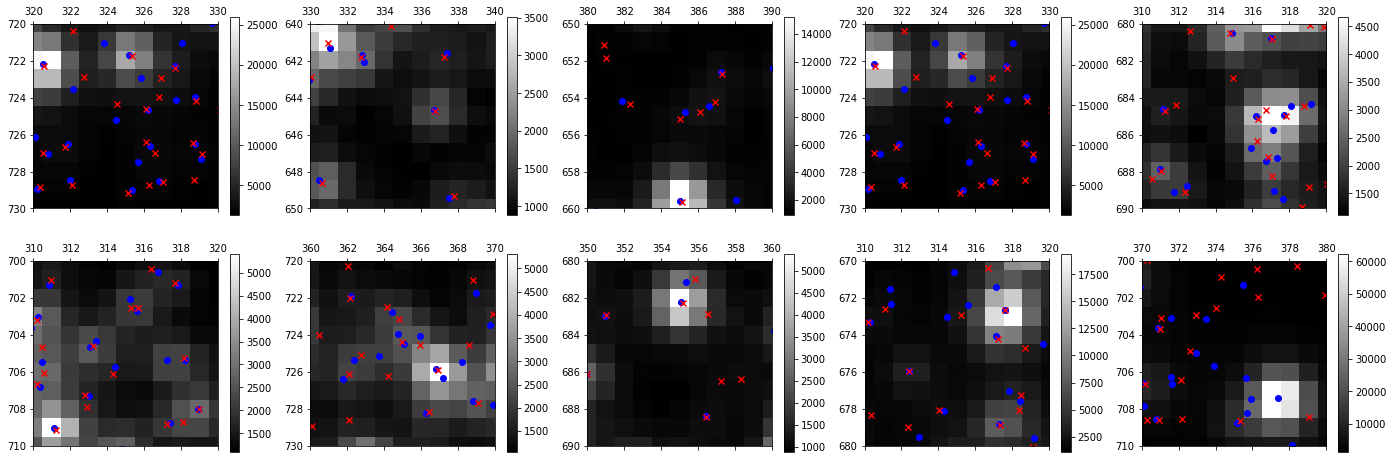

In [16]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
x0_vec = np.arange(x0, x0 + chunk_slen, subimage_slen)
x1_vec = np.arange(x1, x1 + chunk_slen, subimage_slen)

for i in range(10): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        hubble_catalog['locs'], 
        ax,
        marker='o',
        color='b',
    )
    
    plotting.plot_locations(
        map_estimate['locs'].squeeze(), 
        ax,
        marker='x',
        color='r',
    )
    
    im = plotting.plot_image(ax, 
                             sdss_frame[0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

### Summary statistics

In [17]:
from bliss.metrics import get_tpr_ppv

In [18]:
nelec_per_nmgy = 856.09845 # TODO load this somewhere

In [19]:
hubble_test_catalog = plotting.filter_catalog_by_locs(hubble_catalog, 
                                                      x0, x1, chunk_slen, chunk_slen)

In [20]:
hubble_mags = 22.5 - 2.5 * torch.log10(hubble_test_catalog['fluxes'][:, 0:1] / nelec_per_nmgy)
map_mags = 22.5 - 2.5 * torch.log10(map_estimate['fluxes'][0, :, 0:1] / nelec_per_nmgy)


tpr, ppv = get_tpr_ppv(
            hubble_test_catalog['locs'],
            hubble_mags,
            map_estimate['locs'].squeeze(0),
            map_mags,
            slack=0.5,
        )

print('True positive rate: {:.3f}'.format(tpr))
print('Positive predictive value: {:.3f}'.format(ppv))
print('F1: {:.3f}'.format(2 * tpr * ppv / (tpr + ppv)))

True positive rate: 0.556
Positive predictive value: 0.528
F1: 0.541


TODO: the stuff below still needs fixing

# Get summary statistics as a function of magnitude

In [29]:
def get_tpr_vec(
    true_locs, true_mags, est_locs, est_mags, mag_bins
):

    # convert to magnitude
    tpr_vec = np.zeros(len(mag_bins) - 1)
    counts_vec = np.zeros(len(mag_bins) - 1)

    for i in range(len(mag_bins) - 1):
        which_true = (true_mags > mag_bins[i]) & (true_mags < mag_bins[i + 1])
        which_true = which_true.squeeze()
        counts_vec[i] = torch.sum(which_true)

        tpr_vec[i] = get_tpr_ppv(
            true_locs[which_true],
            true_mags[which_true],
            est_locs,
            est_mags,
            slack = 0.5
        )[0]

    return tpr_vec, mag_bins, counts_vec


def get_ppv_vec(
    true_locs, true_mags, est_locs, est_mags, mag_bins
):

    ppv_vec = np.zeros(len(mag_bins) - 1)
    counts_vec = np.zeros(len(mag_bins) - 1)

    for i in range(len(mag_bins) - 1):
        which_est = (est_mags > mag_bins[i]) & (est_mags < mag_bins[i + 1])
        which_est = which_est.squeeze()
        
        counts_vec[i] = torch.sum(which_est)
        
        ppv_vec[i] = get_tpr_ppv(
                    true_locs,
                    true_mags,
                    est_locs[which_est],
                    est_mags[which_est],
                    slack = 0.5
                )[1]
    
    return ppv_vec, mag_bins, counts_vec


In [30]:
# percentiles of the hubble magnitudes.
percentiles = np.linspace(0, 1, 11) * 100
mag_bins = np.percentile(hubble_mags.cpu(), percentiles)
        
# get tpr as function of magnitude
tpr_vec  = \
    get_tpr_vec(hubble_locs * slen,
            hubble_mags,
            map_locs.squeeze() * slen,
            map_mags, 
                mag_bins)[0]

# # get ppv as function of magnitude
ppv_vec  = \
    get_ppv_vec(hubble_locs * slen,
            hubble_mags,
            map_locs.squeeze() * slen,
            map_mags, 
                   mag_bins)[0]

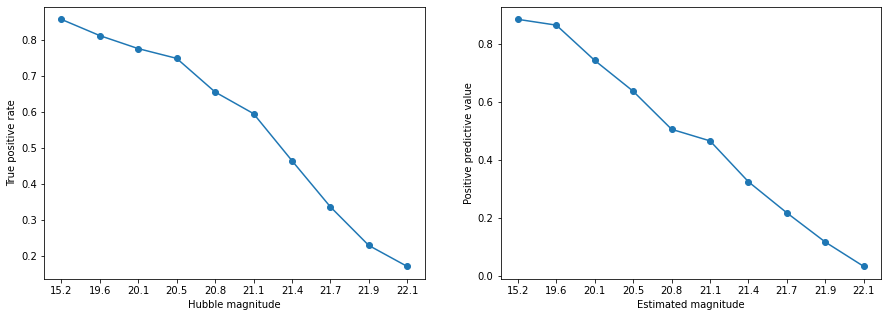

In [31]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))


# plot summary statistics as function of hubble percentile
percentiles = np.linspace(0, 1, 10 + 1) * 100
axarr[0].plot(percentiles[:-1], tpr_vec, '-o')
axarr[1].plot(percentiles[:-1], ppv_vec, '-o')

# axis labels
axarr[0].set_xlabel('Hubble magnitude')
axarr[1].set_xlabel('Estimated magnitude')
axarr[0].set_ylabel('True positive rate')
axarr[1].set_ylabel('Positive predictive value')

# replace percentiles with actual magnitudes
for i in range(2): 
    axarr[i].set_xticks(percentiles[:-1])
    axarr[i].set_xticklabels(np.round(mag_bins, 1)[:-1])


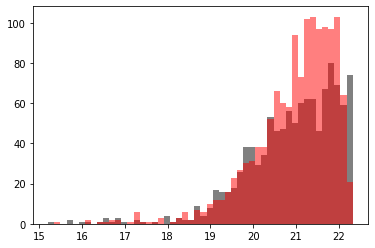

In [32]:
# flux distributions
bins = plt.hist(hubble_mags.cpu().numpy(), color = 'grey', bins = 50);
plt.hist(map_mags.cpu().numpy(), color = 'red', alpha = 0.5, bins = bins[1]);

In [ ]:
# np.savez('../../data/true_hubble_m2', 
#          sdss_image = sdss_image.cpu(), 
#          true_locs = hubble_locs.cpu(), 
#          true_fluxes = hubble_fluxes.cpu(), 
#          nelec_per_nmgy = nelec_per_nmgy)